## KMD Data Analysis

In this notebook, forcing data from different sources used for modeling with Wflow will be analysed. 

- Msc Thesis
- Joris-Martijn Schalkwijk
- NBS in Nakuru, Kenya
- March 2025

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd 
! pip install contextily
import contextily as ctx

### KMD Data

In [ ]:
kmd_stations = pd.read_csv(r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\DATA\2025-03-13 KMD data Ruud\KMD data\KMD_loc.csv")
catchment = gpd.read_file(r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\RESULTS\DEM_basin\basin_outline.gpkg")
output_gpkg = r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\DATA\2025-03-13 KMD data Ruud\Voronoi_polygons.gpkg"

 

C:\Users\jmsch\AppData\Local\Temp\ipykernel_7784\484320044.py:86: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


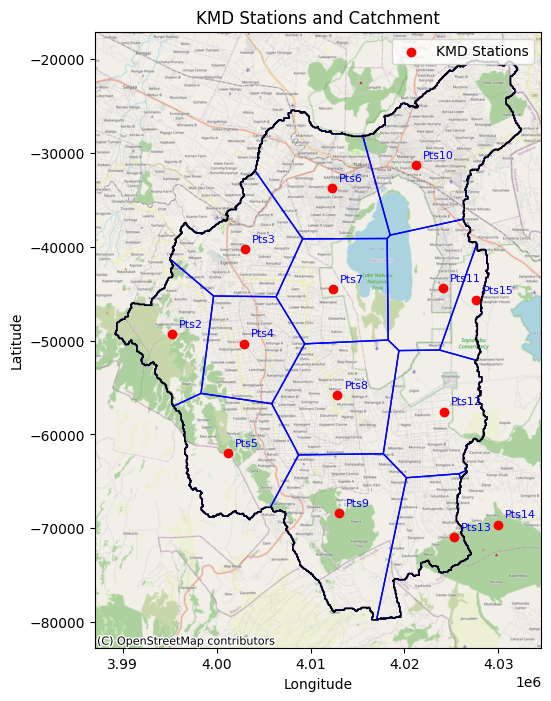

In [ ]:
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(kmd_stations, geometry=gpd.points_from_xy(kmd_stations.LON, kmd_stations.LAT))

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(8, 8))
catchment = catchment.set_crs(epsg=4326, inplace=True)
gdf = gdf.set_crs(epsg=4326, inplace=True)

catchment_3857 = catchment.to_crs(epsg=3857)
gdf_3857 = gdf.to_crs(epsg=3857)


catchment_3857.plot(ax=ax, color='none', edgecolor='black', linewidth=1)
gdf_3857.plot(ax=ax, color='red', label='KMD Stations')

#print(gdf_3857.geometry)
# Add labels for KMD stations
for x, y, label in zip(gdf_3857.geometry.x, gdf_3857.geometry.y, gdf_3857['station']):  # Replace 'Station_Number' with the actual column name for station numbers
    ax.annotate(label, xy=(x,y), xytext=(5, 5), textcoords="offset points", fontsize=8, color='blue')

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)

from shapely.geometry import Point, Polygon
from scipy.spatial import Voronoi

# Create Voronoi polygons
stations_gdf = gdf_3857
catchment_area = catchment_3857
points = np.array([[point.x, point.y] for point in stations_gdf.geometry])
vor = Voronoi(points)

# Create a function to convert Voronoi regions to polygons
def voronoi_finite_polygons_2d(vor, radius=None):
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = np.ptp(vor.points, axis=0).max()
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue
            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]
        new_regions.append(new_region.tolist())
    return new_regions, np.asarray(new_vertices)

regions, vertices = voronoi_finite_polygons_2d(vor)

# Create a GeoDataFrame for the Voronoi polygons
polygons = [Polygon(vertices[region]) for region in regions]
voronoi_gdf = gpd.GeoDataFrame(geometry=polygons, crs=stations_gdf.crs)

# Clip the Voronoi polygons to the catchment area
voronoi_gdf = gpd.clip(voronoi_gdf, catchment_area)

voronoi_gdf.plot(ax=ax, color='none', edgecolor='blue', linewidth=1, label='Catchment Area')
catchment_3857.plot(ax=ax, color='none', edgecolor='black', linewidth=1) 

voronoi_gdf.to_file(output_gpkg, driver="GPKG")

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('KMD Stations and Catchment')

plt.savefig(r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\5. Python\Figures\KMD Stations and Catchment.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
! pip install scipy

In [ ]:
kmd_data = pd.read_csv(r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\DATA\2025-03-13 KMD data Ruud\KMD and Lake\KMD_precipitation.csv", skiprows=4)

In [ ]:
kmd_data['DATE'] = pd.to_datetime(kmd_data['DATE'], format='%Y%m%d')
#display(kmd_data)

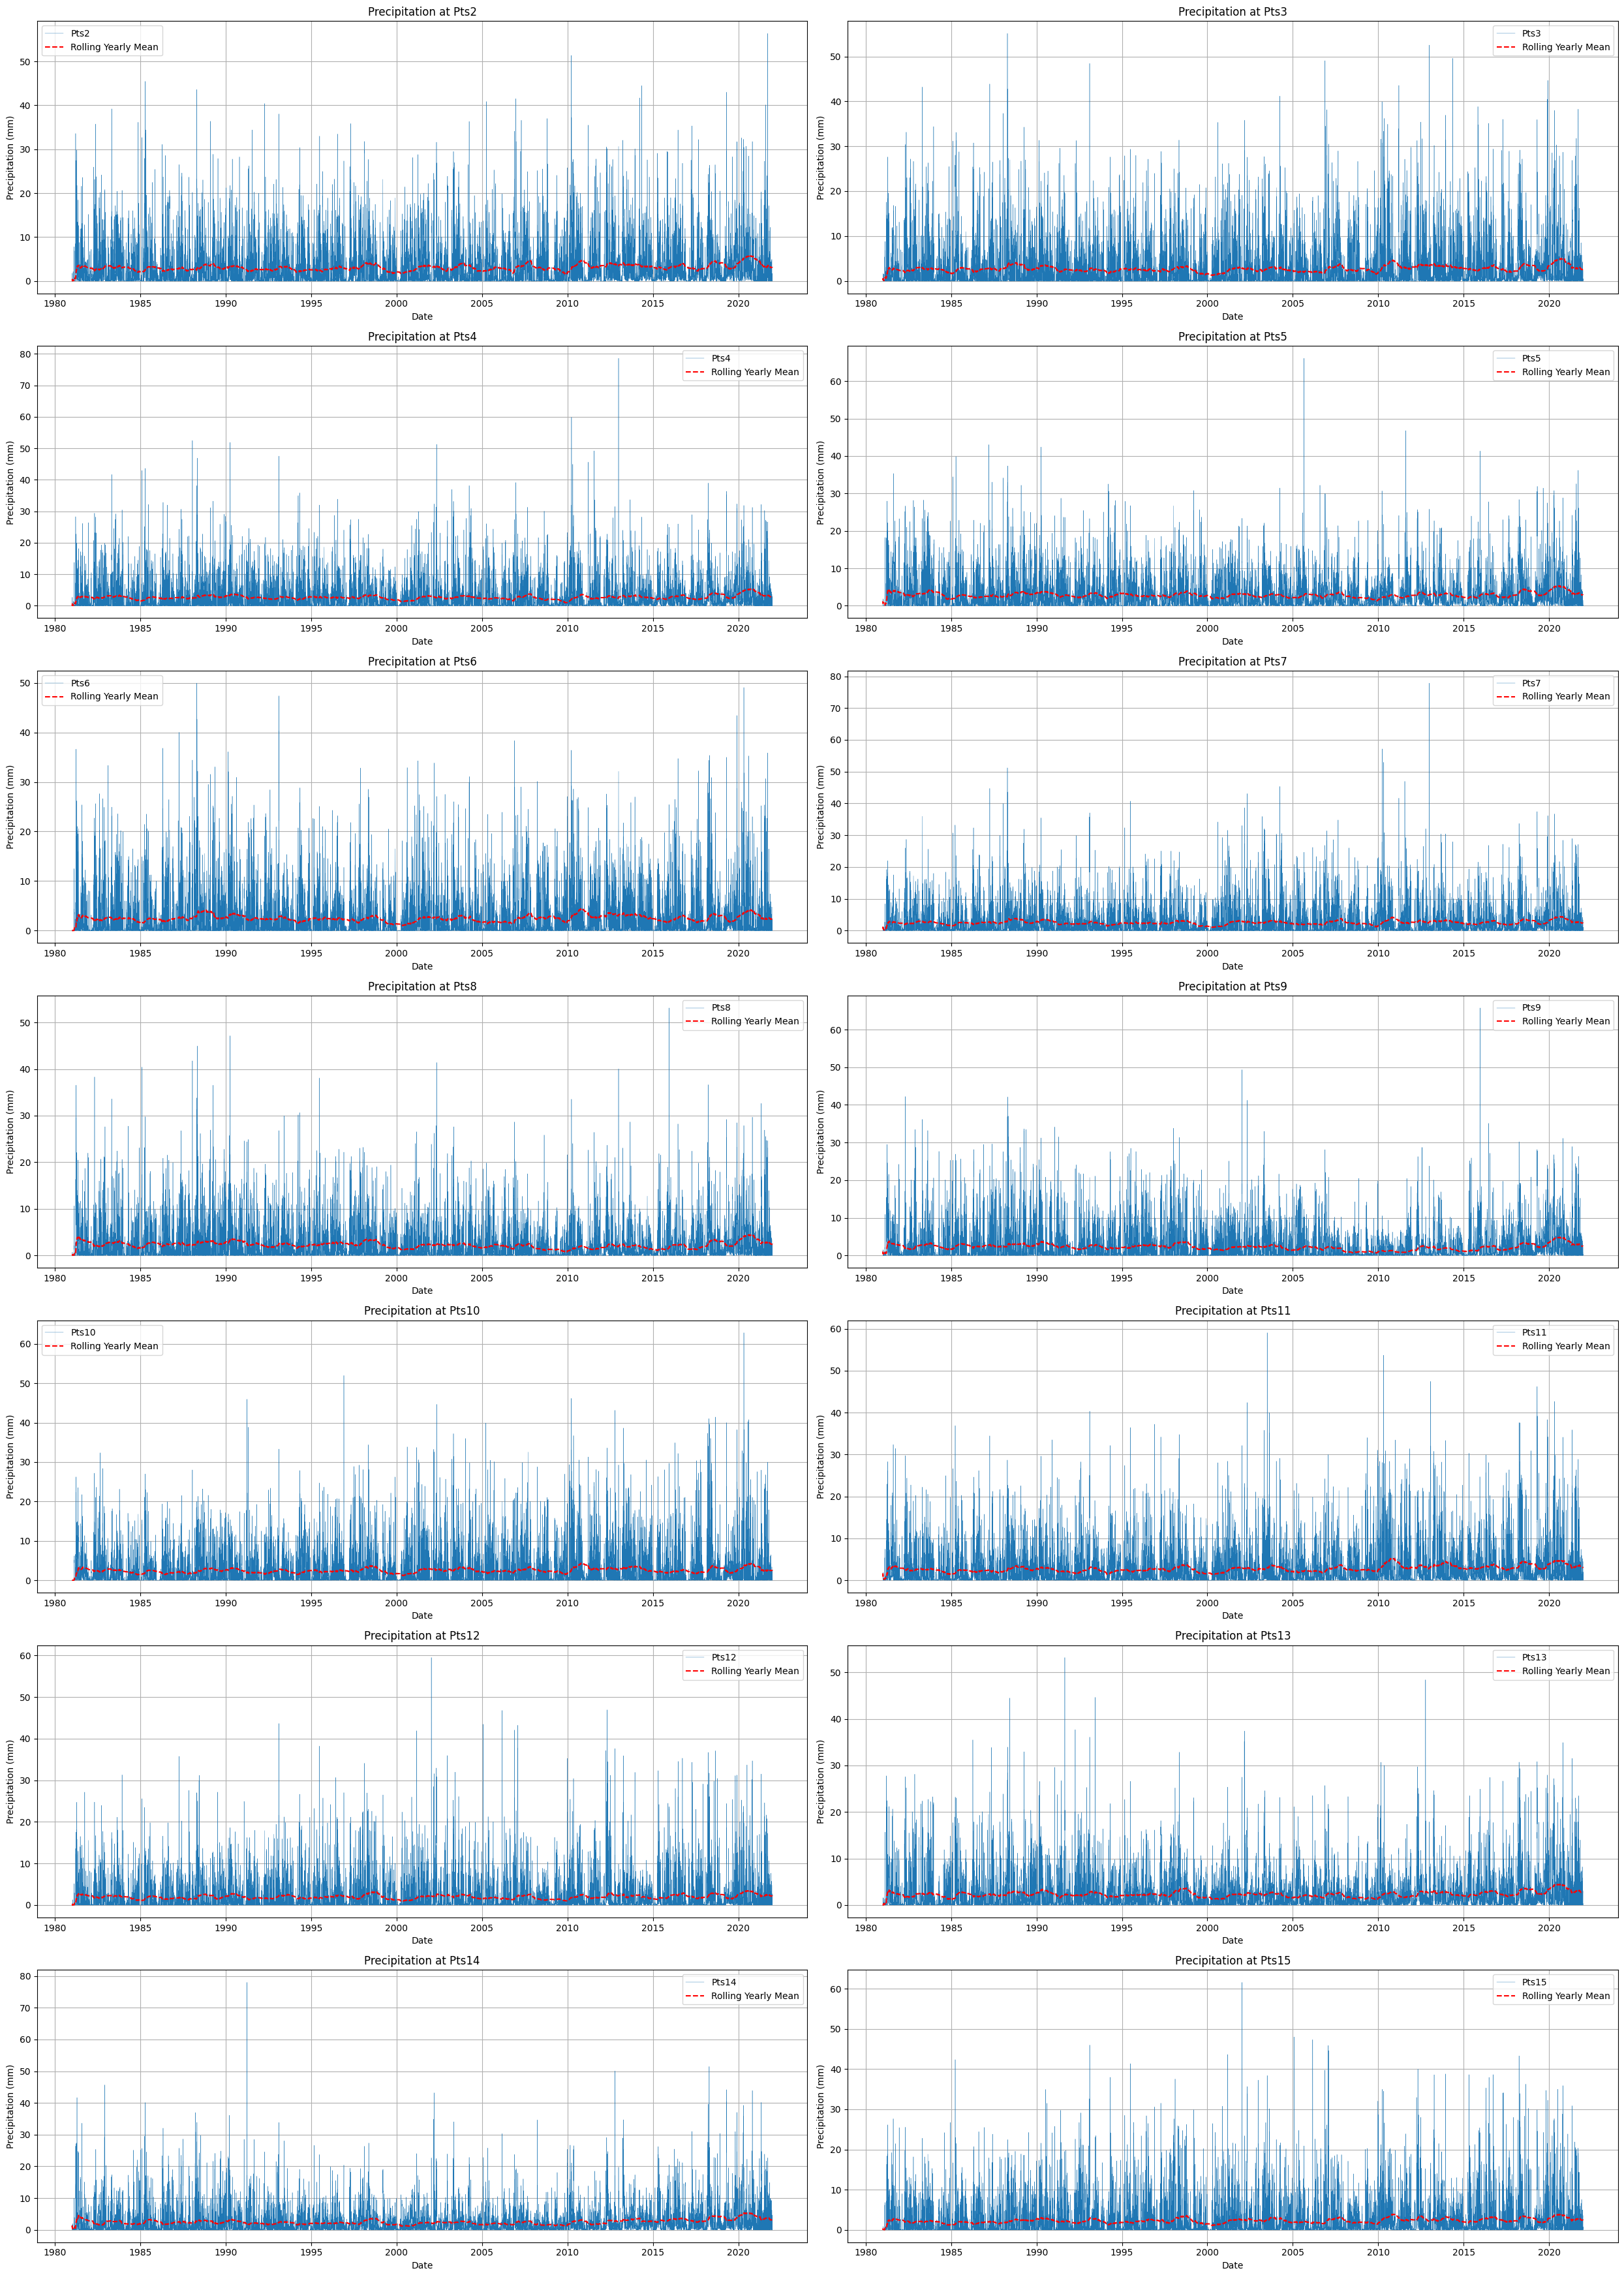

In [ ]:
# Calculate rolling yearly mean precipitation for each station
kmd_data.set_index('DATE', inplace=True)
rolling_mean = kmd_data.rolling(window=365, min_periods=1).mean()

# Create subplots with 2 columns
num_stations = len(kmd_data.columns)
num_rows = (num_stations + 1) // 2
fig, axs = plt.subplots(num_rows, 2, figsize=(25, 5 * num_rows))

for i, station in enumerate(kmd_data.columns):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    
    ax.plot(kmd_data.index, kmd_data[station], label=station, linewidth=0.3)
    
    # Plot rolling yearly mean precipitation
    ax.plot(rolling_mean.index, rolling_mean[station], label='Rolling Yearly Mean', color='red', linestyle='--')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Precipitation (mm)')
    ax.set_title(f'Precipitation at {station}')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.savefig(rf"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\5. Python\Figures\Precipitation at all stations.png", dpi=300, bbox_inches='tight')
plt.show()

C:\Users\jmsch\AppData\Local\Temp\ipykernel_7784\423821770.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_total = kmd_data.resample('M').sum()


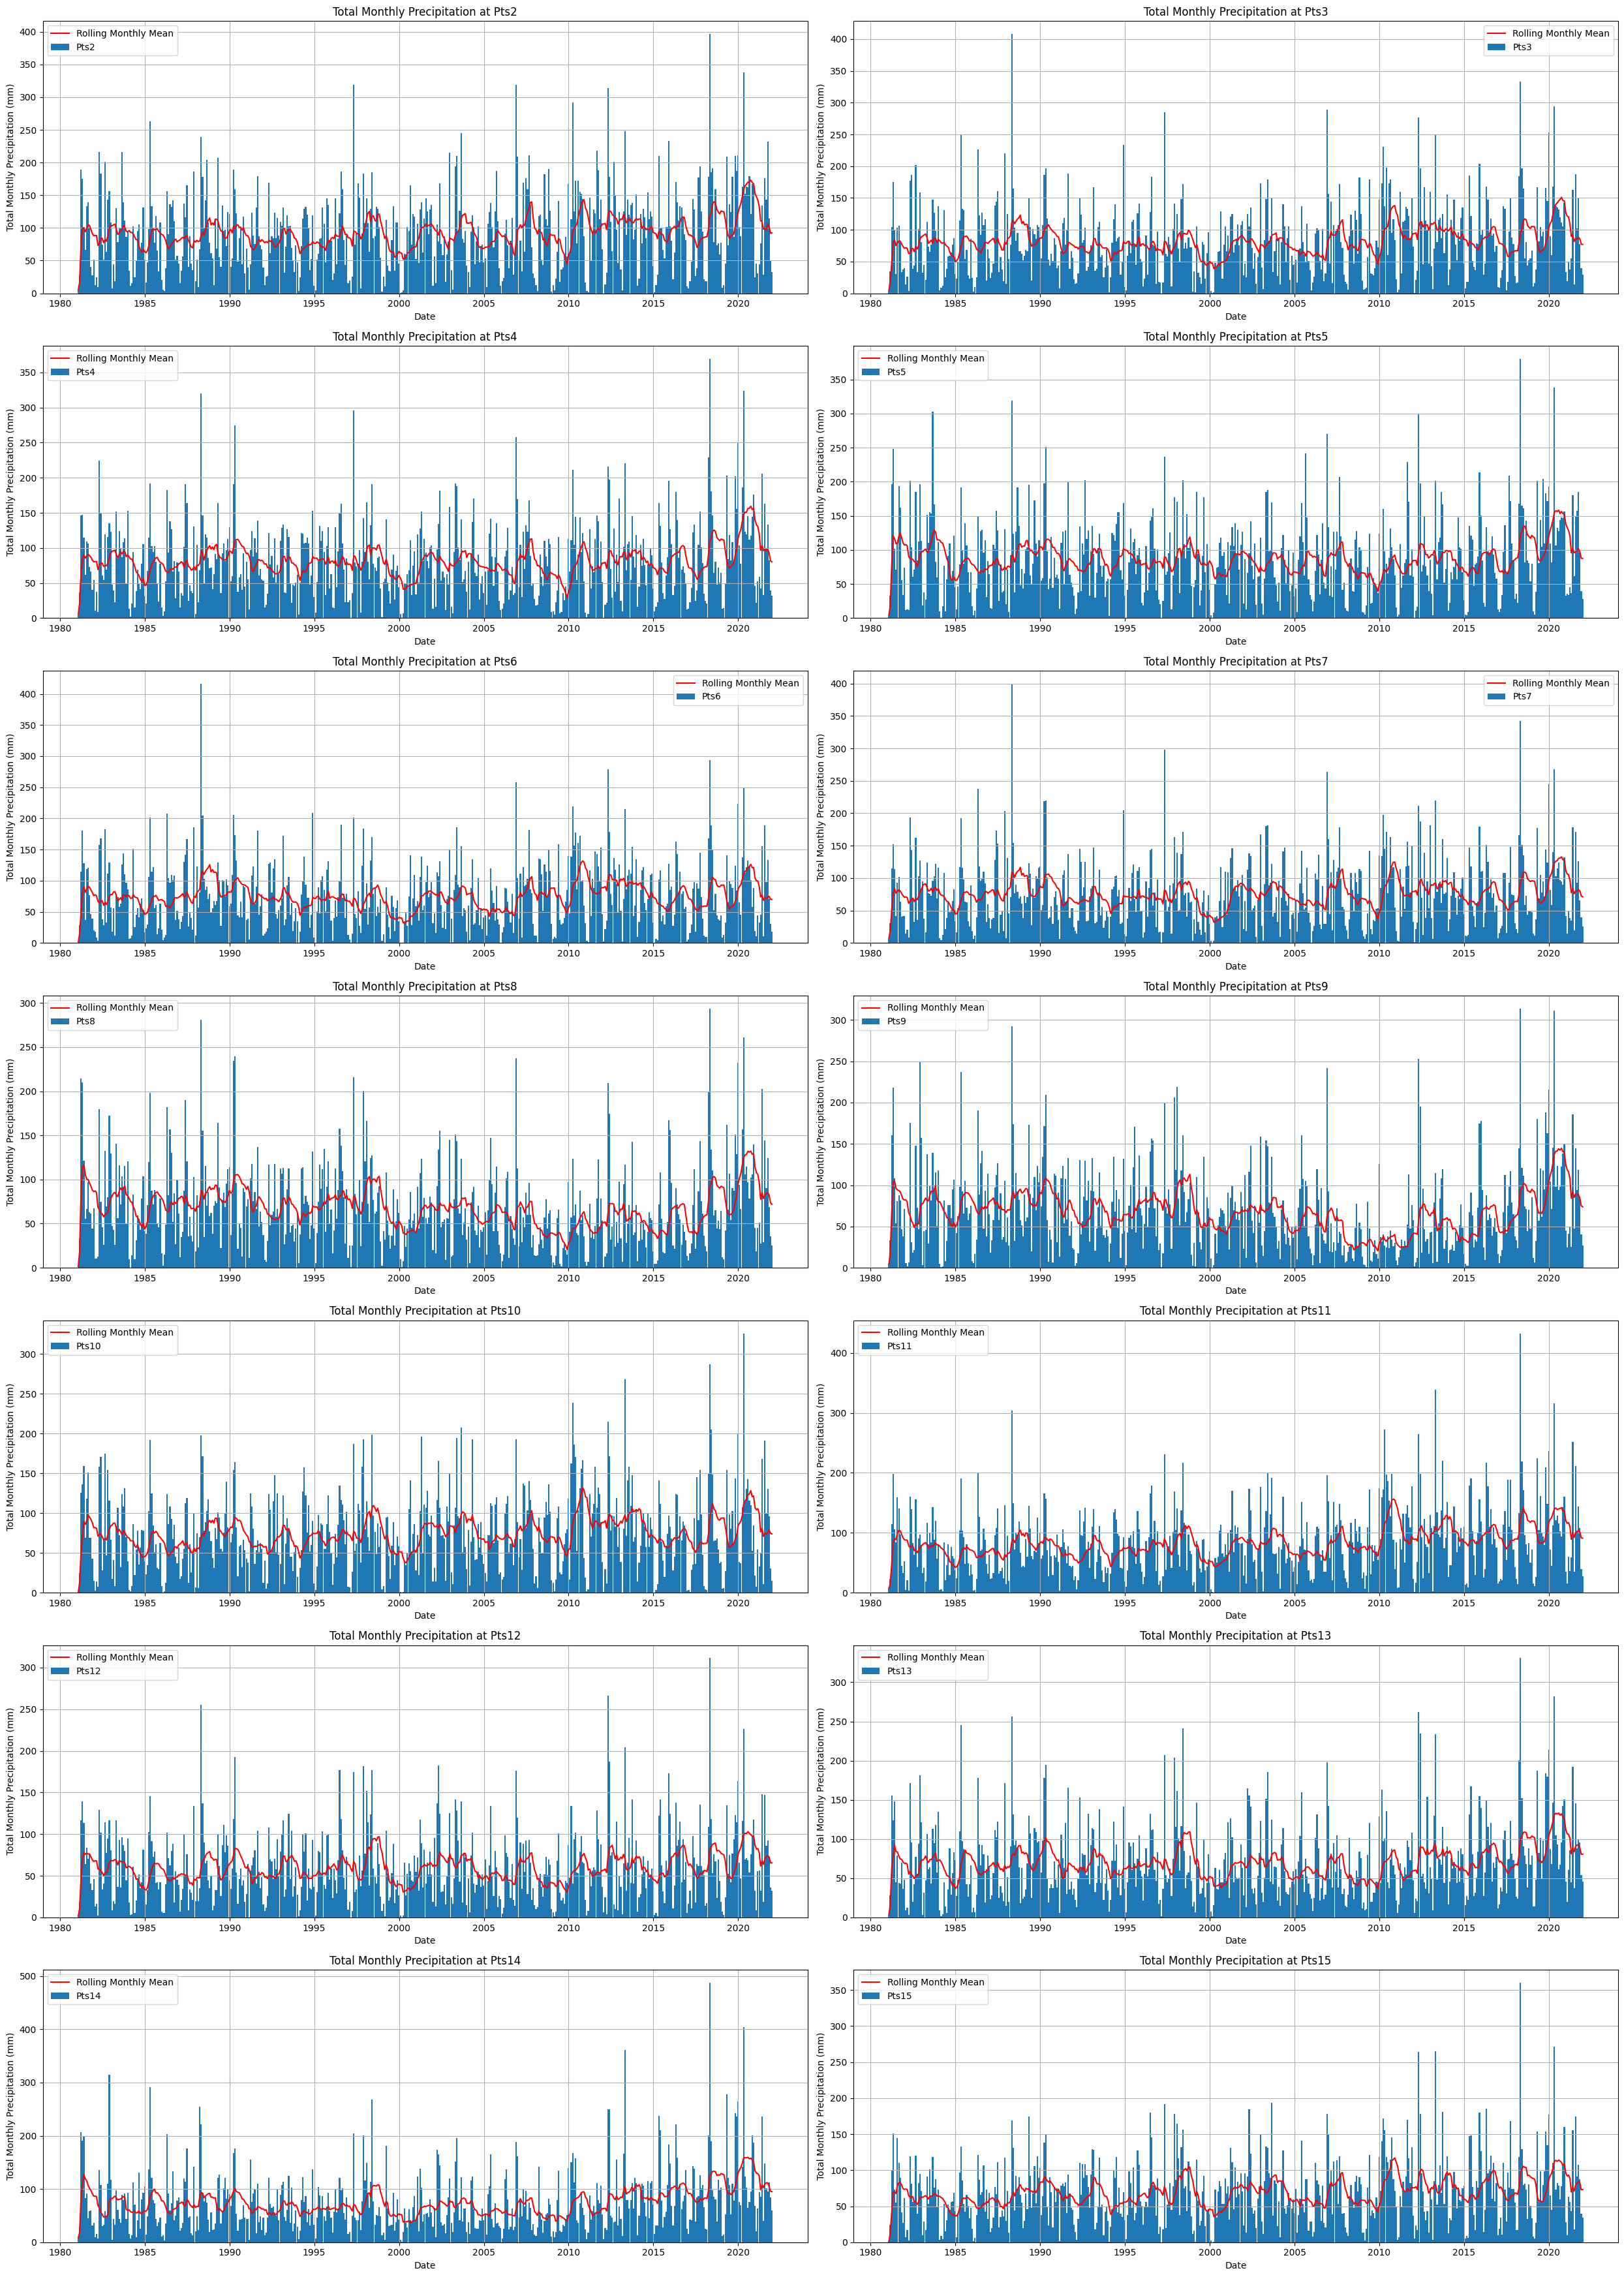

In [ ]:
# Calculate total monthly precipitation for each station
monthly_total = kmd_data.resample('M').sum()

rolling_monthly_mean = monthly_total.rolling(window=12, min_periods=1).mean()

# Create subplots with 2 columns
num_stations = len(monthly_total.columns)
num_rows = (num_stations + 1) // 2
fig, axs = plt.subplots(num_rows, 2, figsize=(25, 5 * num_rows))

for i, station in enumerate(monthly_total.columns):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    
    ax.bar(monthly_total.index, monthly_total[station], label=station, width=30)  # Adjust width for better spacing

    # Plot rolling monthly mean precipitation
    ax.plot(rolling_monthly_mean.index, rolling_monthly_mean[station], label='Rolling Monthly Mean', color='red')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Total Monthly Precipitation (mm)')
    ax.set_title(f'Total Monthly Precipitation at {station}')
    ax.legend()
    ax.grid()

# Remove any empty subplots
if num_stations % 2 != 0:
    fig.delaxes(axs[-1, -1])

plt.tight_layout()
plt.savefig(rf"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\5. Python\Figures\Total Monthly Precipitation at all stations.png", dpi=300, bbox_inches='tight')
plt.show()

To ensure that every month has a bar in the graph, you can use the `bar` method with the `monthly_total` DataFrame. Here is the updated code:



C:\Users\jmsch\AppData\Local\Temp\ipykernel_7784\2999715053.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_total_all = kmd_data.resample('M').sum().groupby(lambda x: x.month).mean()
C:\Users\jmsch\AppData\Local\Temp\ipykernel_7784\2999715053.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_total_last_10_years = last_10_years.resample('M').sum().groupby(lambda x: x.month).mean()


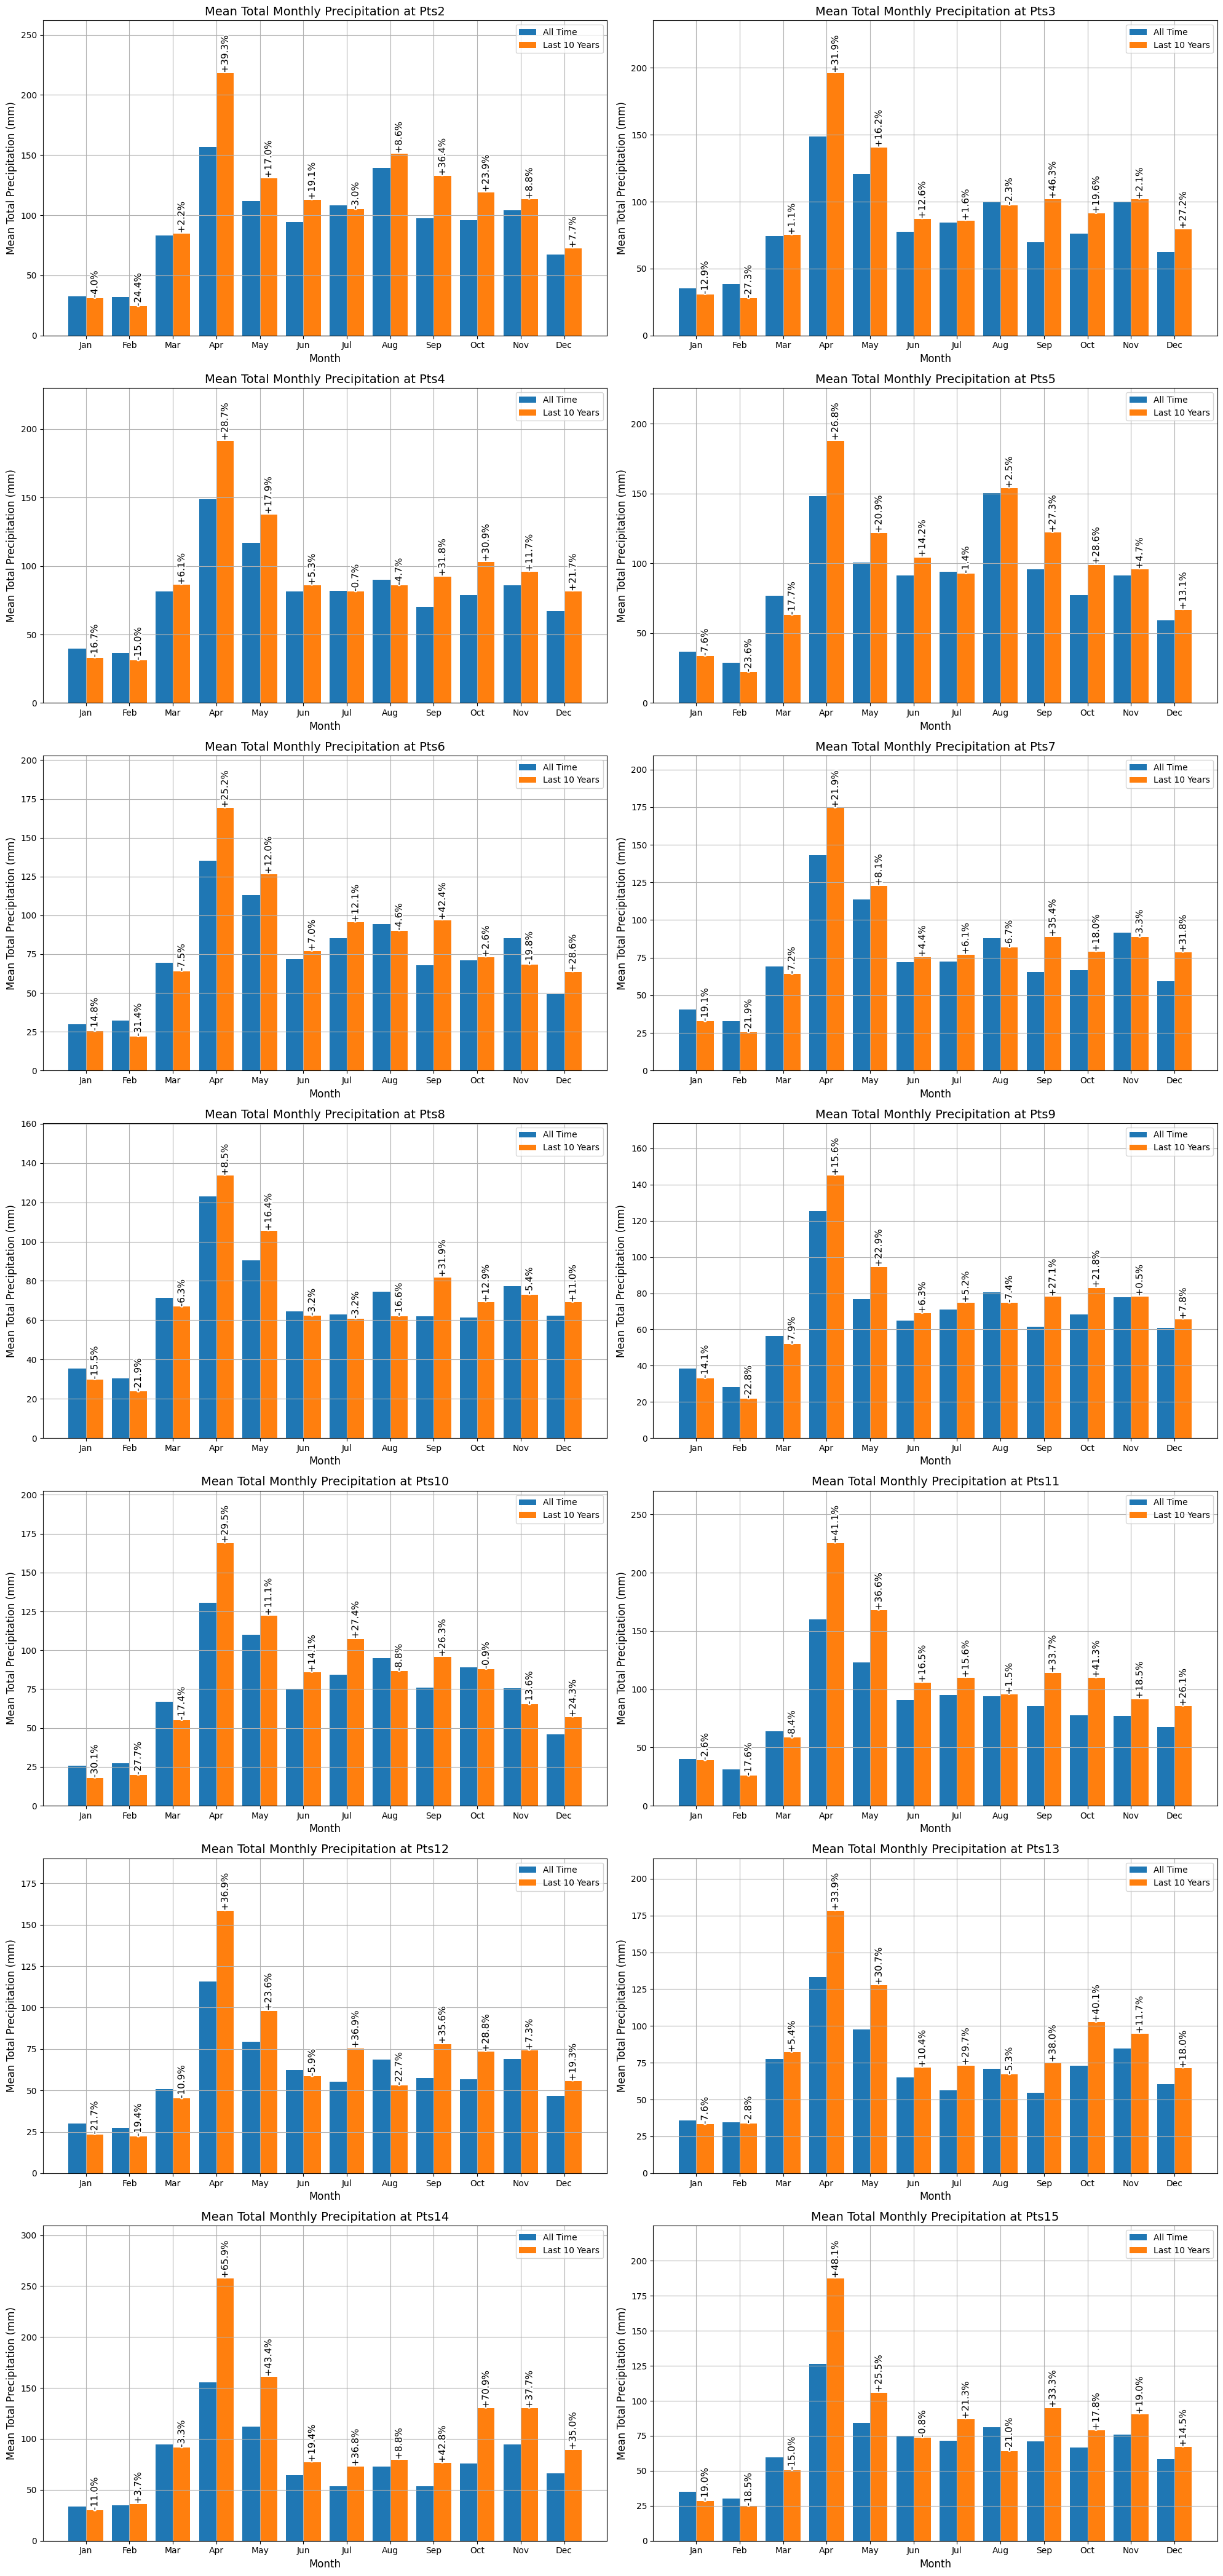

In [ ]:
import matplotlib.patheffects as path_effects

# Calculate total precipitation for each month over the entire time series
monthly_total_all = kmd_data.resample('M').sum().groupby(lambda x: x.month).mean()

# Calculate total precipitation for each month over the last 10 years
last_10_years = kmd_data.loc[kmd_data.index >= (kmd_data.index.max() - pd.DateOffset(years=10))]
monthly_total_last_10_years = last_10_years.resample('M').sum().groupby(lambda x: x.month).mean()

# Create subplots with 2 columns
num_stations = len(kmd_data.columns)
num_rows = (num_stations + 1) // 2
fig, axs = plt.subplots(num_rows, 2, figsize=(20, 6 * num_rows))

for i, station in enumerate(kmd_data.columns):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    
    width = 0.4  # Width of the bars
    months = np.arange(1, 13)
    
    bars_all_time = ax.bar(months - width/2, monthly_total_all[station], width=width, label='All Time', align='center', alpha=1)
    bars_last_10_years = ax.bar(months + width/2, monthly_total_last_10_years[station], width=width, label='Last 10 Years', align='center', alpha=1)
    
    # Calculate and display percentage difference
    for month in months:
        all_time_value = monthly_total_all[station].iloc[month - 1]
        last_10_years_value = monthly_total_last_10_years[station].iloc[month - 1]
        if all_time_value != 0:
            percentage_diff = ((last_10_years_value - all_time_value) / all_time_value) * 100
            sign = '+' if percentage_diff > 0 else ''
            text = ax.text(month + width/2, last_10_years_value, f'{sign}{percentage_diff:.1f}%', ha='center', va='bottom', fontsize=11, color='black', rotation='vertical', verticalalignment='top')
            text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])
    
    ax.set_ylim(0, monthly_total_last_10_years[station].max() * 1.2)
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Mean Total Precipitation (mm)', fontsize=12)
    ax.set_title(f'Mean Total Monthly Precipitation at {station}', fontsize=14)
    ax.set_xticks(months)
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=10)
    ax.legend()
    ax.grid()

# Remove any empty subplots
if num_stations % 2 != 0:
    fig.delaxes(axs[-1, -1])

plt.tight_layout()
plt.savefig(rf"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\5. Python\Figures\Mean Total Monthly Precipitation at all stations.png", dpi=300, bbox_inches='tight')
plt.show()

                                             geometry          area  \
7   POLYGON ((4008732.286 -62173.481, 4017752.005 ...  1.703702e+08   
3   POLYGON ((3998332.432 -55625.926, 4005864.292 ...  1.246301e+08   
2   POLYGON ((4009383.898 -50346.321, 4005864.292 ...  9.627253e+07   
0   POLYGON ((3999673.123 -45251.12, 3998332.432 -...  8.657535e+07   
5   POLYGON ((4018273.148 -49943.471, 4009383.898 ...  1.149363e+08   
1   POLYGON ((4009160.186 -39164.408, 4006329.328 ...  1.068807e+08   
4   POLYGON ((4018485.641 -38768.556, 4018160.156 ...  1.330637e+08   
11  POLYGON ((4020215.014 -64610.068, 4025829.533 ...  7.728570e+07   
12  POLYGON ((4025829.533 -64185.031, 4026565.131 ...  3.175464e+05   
10  POLYGON ((4027599.258 -52088.824, 4027585.56 -...  1.184635e+08   
6   POLYGON ((4019416.828 -51065.937, 4017752.005 ...  1.329733e+08   
9   POLYGON ((4023741.852 -51007.344, 4019416.828 ...  9.998950e+07   
13  POLYGON ((4023741.852 -51007.344, 4027696.063 ...  3.087115e+07   
8   PO

C:\Users\jmsch\AppData\Local\Temp\ipykernel_7784\2458243641.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_total_all = kmd_data.resample('M').sum()
C:\Users\jmsch\AppData\Local\Temp\ipykernel_7784\2458243641.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_total_last_10_years = kmd_data.loc[kmd_data.index >= (kmd_data.index.max() - pd.DateOffset(years=10))].resample('M').sum()


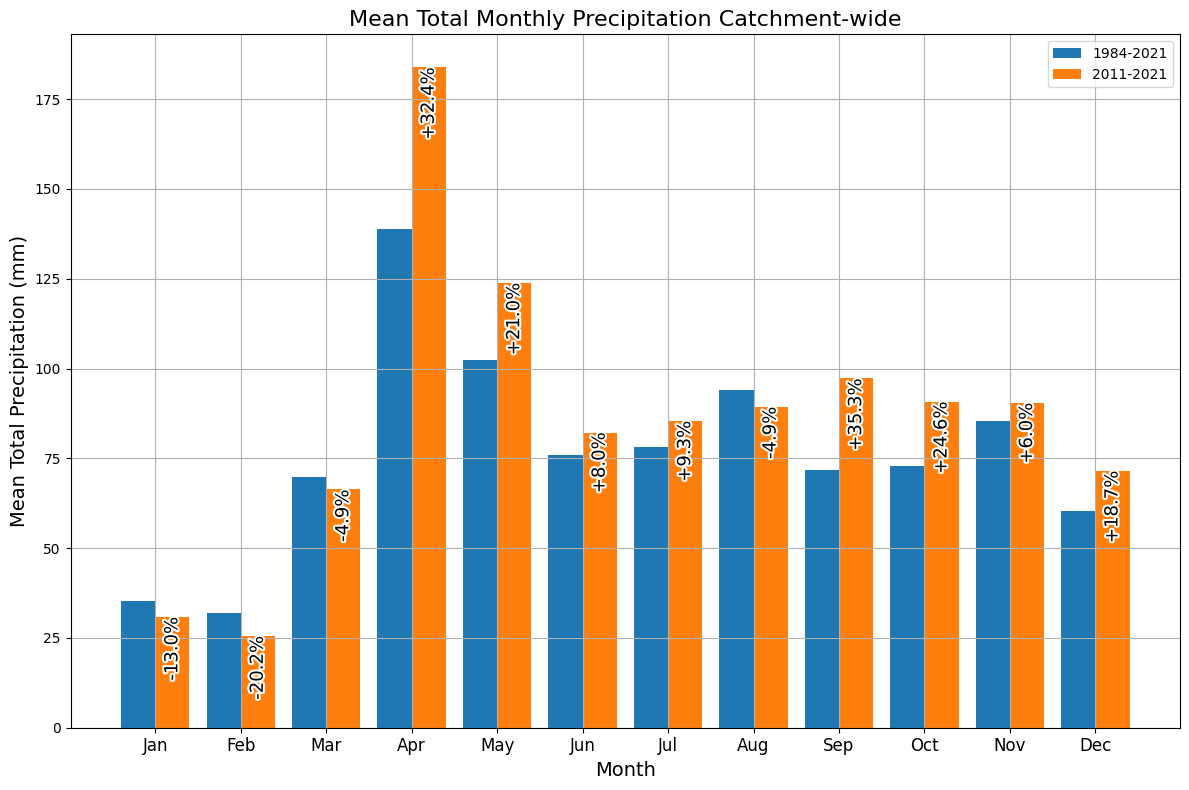

In [ ]:
# Calculate the area of each Voronoi polygon as a fraction of the total catchment area
voronoi_gdf['area'] = voronoi_gdf.area
total_catchment_area = catchment_area.area.sum()
voronoi_gdf['area_fraction'] = voronoi_gdf['area'] / total_catchment_area
#display(kmd_data)

print(voronoi_gdf)

# Calculate the contribution of each station to the precipitation in the whole catchment
#kmd_data['DATE'] = pd.to_datetime(kmd_data['DATE'], format='%Y%m%d')
#kmd_data.set_index('DATE', inplace=True)
monthly_total_all = kmd_data.resample('M').sum()
monthly_total_last_10_years = kmd_data.loc[kmd_data.index >= (kmd_data.index.max() - pd.DateOffset(years=10))].resample('M').sum()

# Calculate the weighted precipitation for each station
weighted_precip_all = monthly_total_all.mul(voronoi_gdf['area_fraction'].values, axis=1)
weighted_precip_last_10_years = monthly_total_last_10_years.mul(voronoi_gdf['area_fraction'].values, axis=1)

# Calculate the mean total precipitation per month for the entire dataset and the last 10 years
mean_total_precip_all = weighted_precip_all.groupby(weighted_precip_all.index.month).mean().sum(axis=1)
mean_total_precip_last_10_years = weighted_precip_last_10_years.groupby(weighted_precip_last_10_years.index.month).mean().sum(axis=1)

# Generate a bar plot
months = np.arange(1, 13)
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.4

ax.bar(months - width/2, mean_total_precip_all, width=width, label='1984-2021', align='center')
ax.bar(months + width/2, mean_total_precip_last_10_years, width=width, label='2011-2021', align='center')

# Calculate and display percentage difference
for month in months:
    all_time_value = mean_total_precip_all.iloc[month - 1]
    last_10_years_value = mean_total_precip_last_10_years.iloc[month - 1]
    if all_time_value != 0:
        percentage_diff = ((last_10_years_value - all_time_value) / all_time_value) * 100
        sign = '+' if percentage_diff > 0 else ''
        text = ax.text(month + width/2, last_10_years_value, f'{sign}{percentage_diff:.1f}%', ha='center', va='top', rotation='vertical',fontsize=13, color='black')
        text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])

ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Mean Total Precipitation (mm)', fontsize=14)
ax.set_title('Mean Total Monthly Precipitation Catchment-wide', fontsize=16)
ax.set_xticks(months)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
ax.legend()
ax.grid()

plt.tight_layout()
plt.savefig(rf"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\5. Python\Figures\Mean Total Monthly Precipitation Catchment-wide.png", dpi=300, bbox_inches='tight')
plt.show()



This code will create a figure with subplots arranged in a grid with 2 columns. Each subplot will display the total monthly precipitation for each station using bar plots, ensuring that every month has a bar. The width of the bars is adjusted for better spacing. The final figure is saved as a single image file.

C:\Users\jmsch\AppData\Local\Temp\ipykernel_7784\2636347357.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  total_precip_last_10_years_monthly = total_precip_last_10_years.resample('M').sum()


DatetimeIndex(['2011-12-31', '2012-01-31', '2012-02-29', '2012-03-31',
               '2012-04-30', '2012-05-31', '2012-06-30', '2012-07-31',
               '2012-08-31', '2012-09-30',
               ...
               '2021-03-31', '2021-04-30', '2021-05-31', '2021-06-30',
               '2021-07-31', '2021-08-31', '2021-09-30', '2021-10-31',
               '2021-11-30', '2021-12-31'],
              dtype='datetime64[ns]', name='DATE', length=121, freq='ME')

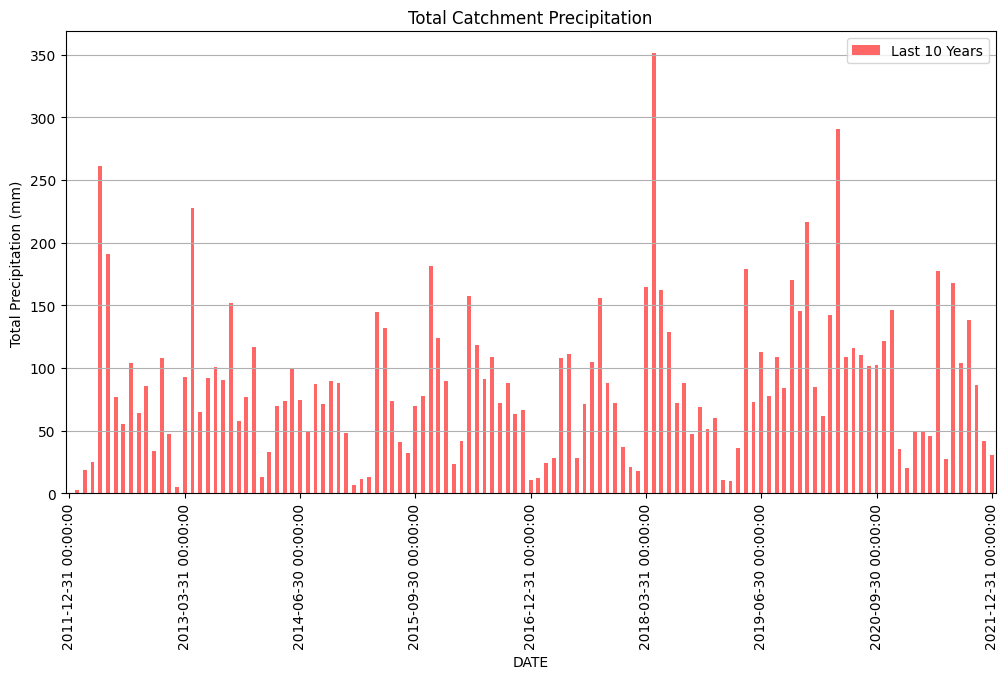

In [ ]:
from matplotlib.ticker import MaxNLocator
import matplotlib.dates	as mdates

# Sum the weighted precipitation to get the total catchment precipitation
total_precip_all = weighted_precip_all.sum(axis=1)

# Calculate the weighted precipitation for the last 10 years
kmd_data_last_10_years = kmd_data.loc[kmd_data.index >= (kmd_data.index.max() - pd.DateOffset(years=10))]
weighted_precip_last_10_years = kmd_data_last_10_years.mul(voronoi_gdf['area_fraction'].values, axis=1)
total_precip_last_10_years = weighted_precip_last_10_years.sum(axis=1)

# Resample to monthly data for bar plot
#total_precip_all_monthly = total_precip_all.resample('M').sum()
total_precip_last_10_years_monthly = total_precip_last_10_years.resample('M').sum()

# Plot the total catchment precipitation time series as bar plots
fig, ax = plt.subplots(figsize=(12, 6))
#total_precip_all_monthly.plot(kind='bar', ax=ax, label='All Time', color='blue', alpha=0.6)
total_precip_last_10_years_monthly.plot(kind = 'bar', ax=ax, label='Last 10 Years', color='red', alpha=0.6)


display(total_precip_last_10_years_monthly.index)
ax.xaxis.set_major_locator(MaxNLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#ax.set_xticklabels(total_precip_last_10_years_monthly.index.year, rotation=0, ha='right')
ax.set_title('Total Catchment Precipitation')
ax.set_ylabel('Total Precipitation (mm)')
ax.legend()
ax.grid(axis='y')

# Save the figure to a folder
fig.savefig(r'C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\5. Python\Figures\Total_Catchment_Precipitation.png', dpi=300, bbox_inches='tight')

plt.show()

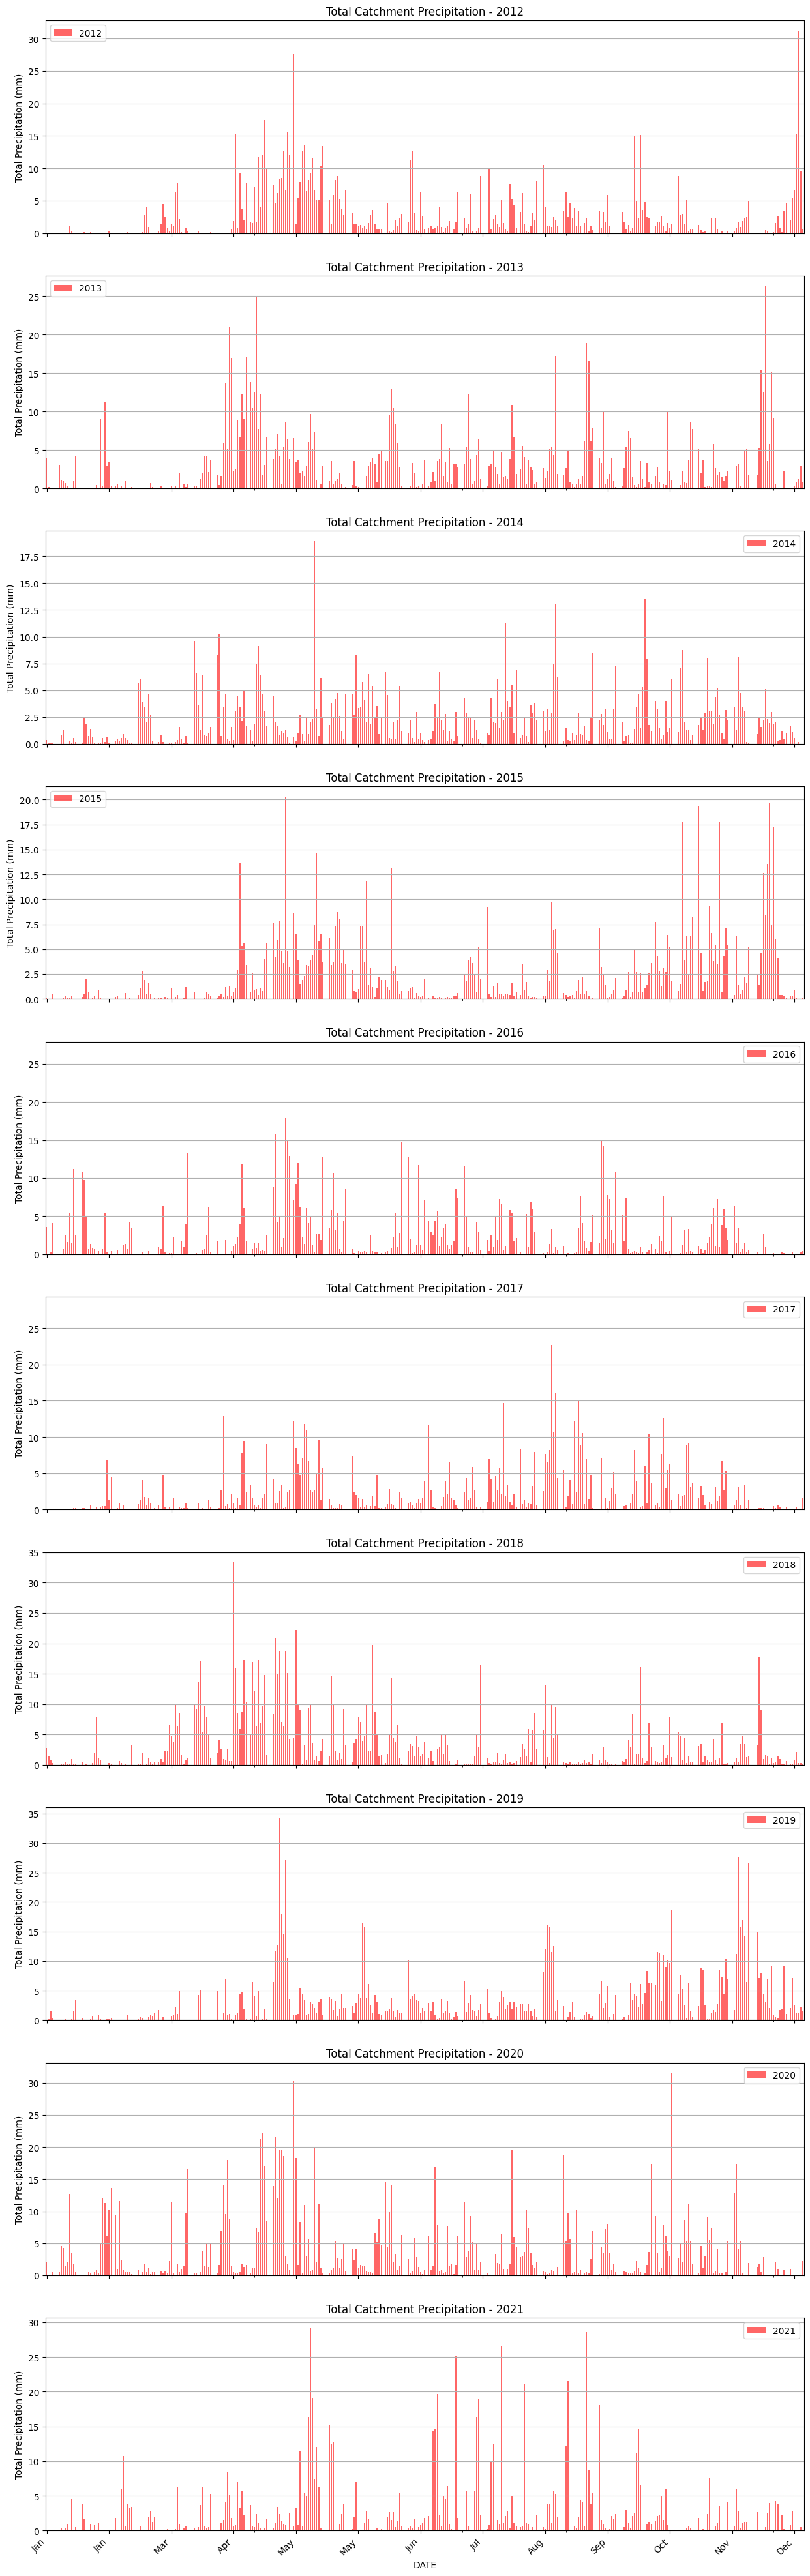

In [ ]:
# Filter out the year 2011
total_precip_last_10_years = total_precip_last_10_years[total_precip_last_10_years.index.year != 2011]

# Create subplots for each year within the last 10 years, with the daily precipitation
years = total_precip_last_10_years.index.year.unique()
num_years = len(years)
fig, axs = plt.subplots(num_years, 1, figsize=(15, 5 * num_years), sharex=True)

for i, year in enumerate(years):
    ax = axs[i]
    yearly_data = total_precip_last_10_years[total_precip_last_10_years.index.year == year]
    yearly_data.plot(kind='bar', ax=ax, label=f'{year}', color='red', alpha=0.6)
    ax.set_title(f'Total Catchment Precipitation - {year}')
    ax.set_ylabel('Total Precipitation (mm)')
    ax.legend()
    ax.grid(axis='y')
    
    # Set x-axis ticks to show only the months
    ax.set_xticks(range(0, len(yearly_data), 30))
    ax.set_xticklabels(yearly_data.index[::30].strftime('%b'), rotation=45, ha='right')

# Save the figure to a folder
fig.savefig(r'C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\5. Python\Figures\Total_Catchment_Precipitation_Last_10_Years.png', dpi=300, bbox_inches='tight')

plt.show()

### TAHMO Data

For comparison and validation, the satellite data products from KMD, ERA5 and CHIRPS are compared to TAHMO weather station observations. In the Catchment, two THAMO stations are present. 

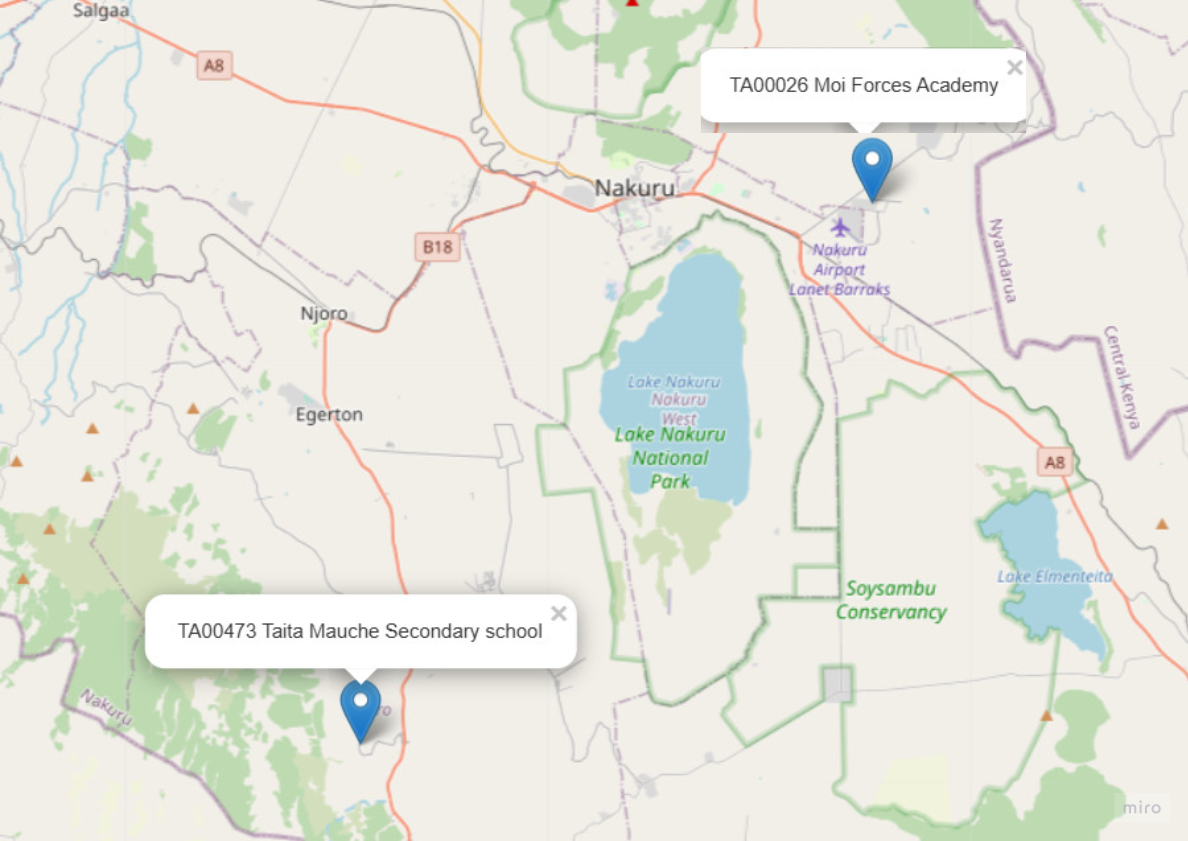 ![KMD Stations and Catchment.png](<attachment:KMD Stations and Catchment.png>)
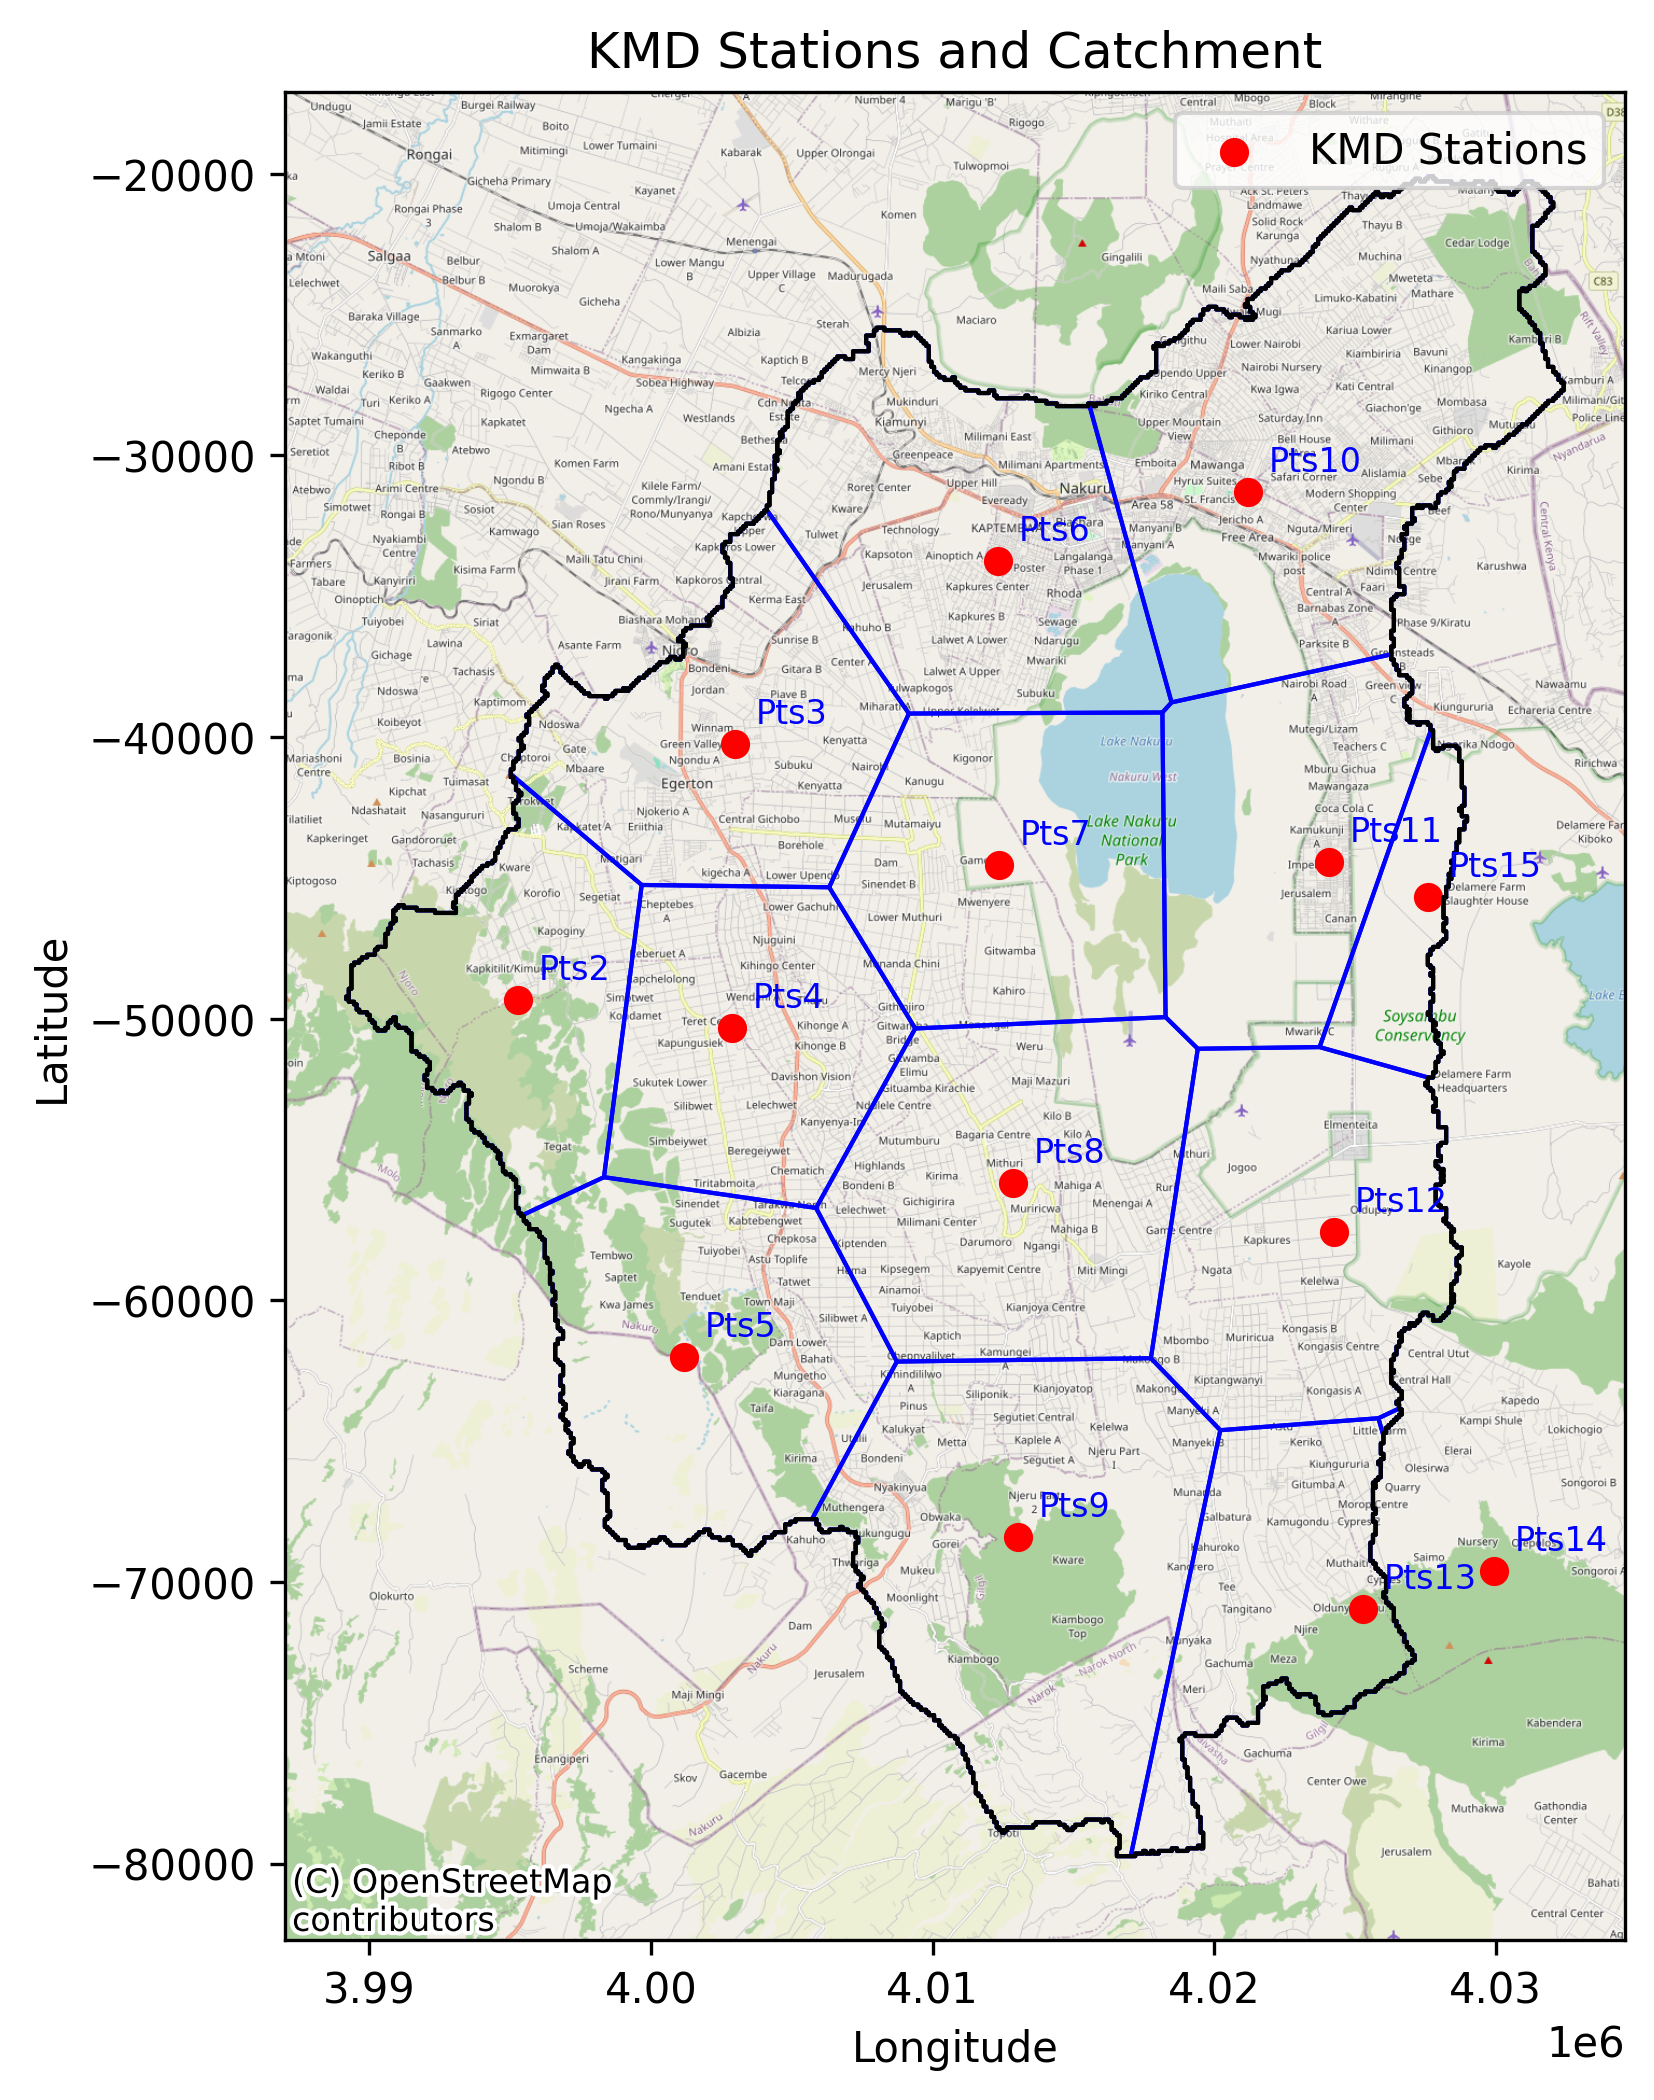

In [ ]:
TA00473 = pd.read_csv(r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\DATA\2025-04-03 TAHMO\TA00473.csv")
TA00026 = pd.read_csv(r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\DATA\2025-04-03 TAHMO\TA00026.csv")

In [ ]:
#display(TA00473)
TA00473['timestamp'] = pd.to_datetime(TA00473['timestamp'], format='%d/%m/%Y %H:%M')
TA00473.set_index('timestamp', inplace=True)
#display(TA00026)

In [ ]:

TA00473 = TA00473.resample('D').sum()
TA00473 = TA00473.loc[(TA00473.index >= '2007-01-01') & (TA00473.index <= '2021-12-31')]
#display(TA00473)

In [ ]:
#display(TA00026)
TA00026['timestamp'] = pd.to_datetime(TA00026['timestamp'], format='%Y-%m-%d %H:%M')
TA00026.set_index('timestamp', inplace=True)

In [ ]:
TA00026 = TA00026.resample('D').sum()
TA00026 = TA00026.loc[(TA00026.index >= '2007-01-01') & (TA00026.index <= '2021-12-31')]

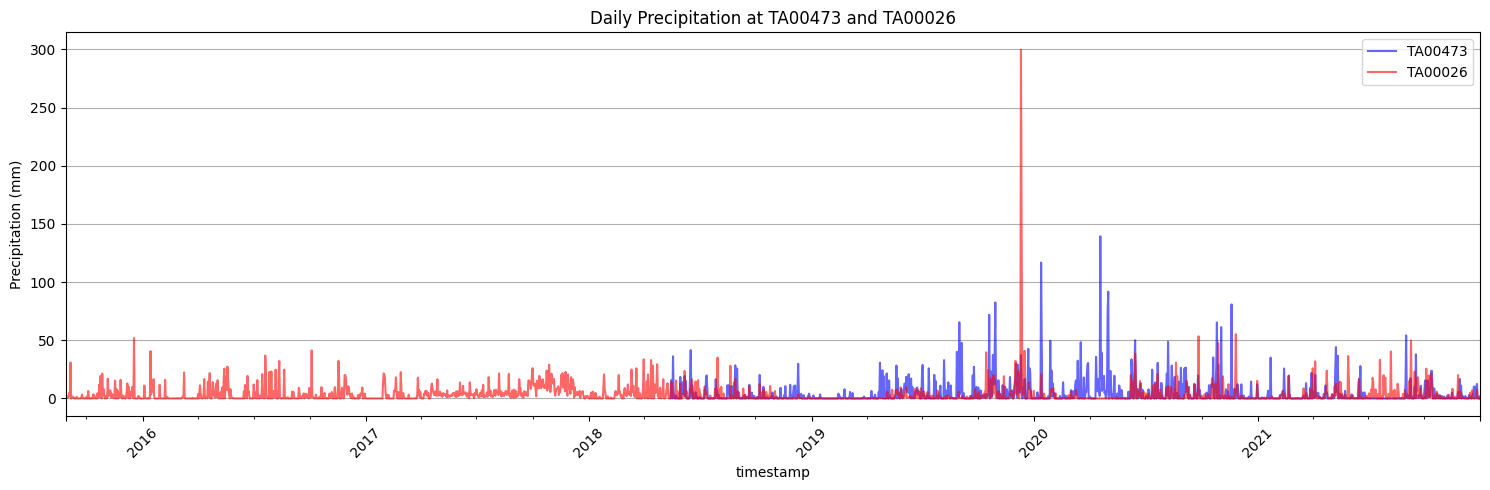

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

TA00473['precipitation (mm)'].plot(ax=ax, label='TA00473', color='blue', alpha=0.6)
TA00026['precipitation (mm)'].plot(ax=ax, label='TA00026', color='red', alpha=0.6)
ax.set_title('Daily Precipitation at TA00473 and TA00026')
ax.set_ylabel('Precipitation (mm)')
ax.legend()
ax.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
